In [1]:
# Necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Package for processing EDF++ files
import mne

# Libraries for machine learning via sklearn:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

<h2>Importing The Raw EEG recording</h2>

In [2]:
# Necessary file names ready to go:
path = r"C:\Users\Jason Ha\Documents\University\4th Year\Thesis Project (Repo)\Jupyter Notebooks\Active Projects\mass_data\01-02-0001_PSG"
file = r"01-02-0001_PSG.edf"
scorer_annot_1 = r"01-02-0001_Annotations.csv"
scorer_annot_2 = r"01-02-0001_Annotations2.csv"
sleep_stages_filename = r"01-02-0001_Stages.edf"

# Load raw MNE file. Preload = False (Save hard drive memory):
raw_file = path + "\\" + file
raw = mne.io.read_raw_edf(raw_file, preload=False, verbose=False)

# Load annotations per the sleep stage EDF file into workspace
sleep_stages_file = path + "\\" + sleep_stages_filename
stages = mne.read_annotations(sleep_stages_file)

# Set the annotations onto the raw file:
raw.set_annotations(stages)

# Perform preliminary bandpass filtering on the entire signal in 11-16 Hz:
raw = raw.load_data().filter(11.0, 16.0, fir_window='hann', fir_design='firwin')

# Get the event and event_id from the annotations:
event, event_id = mne.events_from_annotations(raw)

# Create epochs from the event and event_id
epochs = mne.Epochs(raw, event, event_id, tmin=0.0, tmax=20, baseline=None) # 20 second epochs (based off stage annotations)

# Create dataframe from epochs
epochs_df = epochs.to_data_frame()

<ipython-input-2-7b130628d48a>:10: RuntimeWarning: 2 channel names are too long, have been truncated to 15 characters:
['EOG Lower Vertic', 'EOG Upper Vertic']
  raw = mne.io.read_raw_edf(raw_file, preload=False, verbose=False)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage ?', 'Sleep stage R', 'Sleep stage W']
1419 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 1419 events and 5121 original time points ...
0 bad epochs dropped
Converting "time" to "<class 'numpy.int64'>"...


In [10]:
raw.info['sfreq']

256.0163850486431

<h2>Converting Epochs To DataFrame</h2>

The annotations have allowed the each channel of the PSG recording to be divided into epochs based on the onset of each sleep stage (provided with each patient) data. The dataframe contains  related to EEG as well as EOG, EMG, Blood oxygen etc. Specifically, we want the EEG C3-LER channel as the spindles came from this channel. 

In [3]:
epochs_df.head()

channel                   EOG Right Horiz  Resp nasal  EEG Pz-LER  \
condition     epoch time                                            
Sleep stage ? 0     0            4.683698    0.627158   12.265569   
                    4            3.864176    0.687507    9.594047   
                    8            2.719235    0.690341    6.296220   
                    12           1.364900    0.634803    2.877359   
                    16          -0.064913    0.528085   -0.210787   

channel                   EEG Fp1-LER  EMG Chin  EEG Fpz-LER  EEG Cz-LER  \
condition     epoch time                                                   
Sleep stage ? 0     0        5.271530  3.118674     5.304243    4.871029   
                    4        4.613539  4.148112     4.444753    3.707615   
                    8        3.540250  4.601766     3.204895    2.240140   
                    12       2.152918  4.431217     1.702691    0.610936   
                    16       0.582579  3.678852     0.078547   -1.027673   

channel                   EEG O1-LER  EEG C4-LER  EEG F3-LER  ...  EEG F8-LER  \
condition     epoch time                                      ...               
Sleep stage ? 0     0      -0.677967    2.923376    5.277497  ...    3.540641   
                    4      -2.182299    2.020055    4.448492  ...    2.915794   
                    8      -3.554960    0.997406    3.238044  ...    2.040634   
                    12     -4.631938   -0.043724    1.751150  ...    1.012068   
                    16     -5.272941   -1.010617    0.117380  ...   -0.062198   

channel                   EOG Upper Verti  EEG T6-LER  EEG T4-LER  EEG F7-LER  \
condition     epoch time                                                        
Sleep stage ? 0     0            2.235578    0.854104    2.527208    3.705303   
                    4            2.296070    0.740209    2.298781    2.878589   
                    8            2.046000    0.544126    1.830172    1.825049   
                    12           1.573807    0.307507    1.184219    0.641209   
                    16           1.006911    0.076562    0.443692   -0.569329   

channel                   EEG P3-LER     ECG I  EEG A2-LER  EEG F4-LER  \
condition     epoch time                                                 
Sleep stage ? 0     0       1.211671  9.756096   -0.576205    4.034499   
                    4       0.486242  9.594532    0.515864    3.037069   
                    8      -0.306514  8.462559    1.511362    1.802408   
                    12     -1.082784  6.681436    2.284702    0.456082   
                    16     -1.755891  4.657876    2.752169   -0.872951   

channel                   EEG T3-LER  
condition     epoch time              
Sleep stage ? 0     0       1.902730  
                    4       1.242841  
                    8       0.491379  
                    12     -0.273916  
                    16     -0.977594  

[5 rows x 27 columns]

Pulling out the EEG C3-LER channel and epochs strictly in sleep stage 2 (N2)

In [4]:
eeg_epochs_df = epochs_df[['EEG C3-LER']]
eeg_epochs = eeg_epochs_df.loc["Sleep stage 2", :]
eeg_epochs

channel      EEG C3-LER
epoch time             
13    0       -2.081539
      4       -1.879385
      8       -1.420351
      12      -0.752049
      16       0.046796
...                 ...
1409  19983   -2.112514
      19987   -1.846403
      19991   -1.375927
      19995   -0.765505
      19999   -0.096736

[3815145 rows x 1 columns]

In [5]:
eeg_epochs.index.values

array([(13, 0), (13, 4), (13, 8), ..., (1409, 19991), (1409, 19995),
       (1409, 19999)], dtype=object)

Since each epoch is 20 seconds long, we can multiply the epoch number by the duration of the epoch (20 seconds) to get the actual time (in seconds) in the EEG reading we are observing. We can use this later on when we want to compare the epoch and frame we are currently sampling and matching it to the ground truth annotations.

<h1>Visualising An Epoch (20 second duration)</h1>

First step is to get a list of the unique epochs in the dataframe we are working with. This way, we can just access the epochs based on index rather than the actual epoch number.

In [6]:
# Get all the unique epochs from the dataframe:
temp = epochs_df.reset_index(drop=False)
tmp = temp[temp['condition'] == 'Sleep stage 2']
epoch_list = tmp['epoch'].unique()

The total number of epochs in the dataframe we are considering is:

We pull out a single epoch as an example for this mock procedure. In this case, we pick an epoch which we know will contain spindle annotations. However, the script will automatically scan through each epoch one-by-one in order to determine the epochs that contain the annotations.

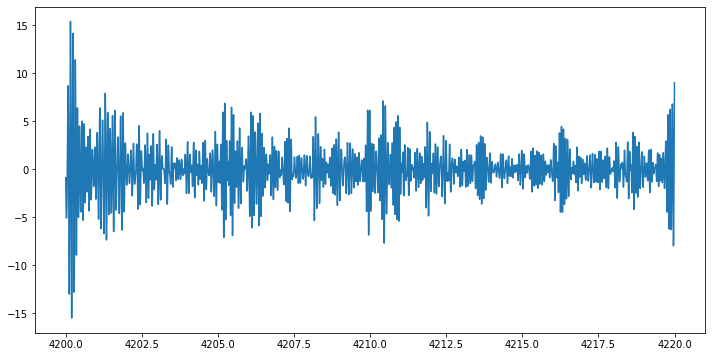

In [7]:
epoch = epoch_list[51]
example = eeg_epochs.loc[epoch]
signal = example['EEG C3-LER']

# Make time axis reflect the true time-value it was extracted from (from full EEG recording)
time = example.index.values / 1000
time = time + (epoch * 20)

fig = plt.figure(figsize=(12,6))
plt.plot(time, signal)
plt.show()

In [8]:
signal.interpolate(method='time').fillna(0)

time
0       -0.875636
4       -2.182799
8       -3.247977
12      -4.054878
16      -4.612283
           ...   
19983   -0.280018
19987    2.677003
19991    5.423508
19995    7.627978
19999    9.011707
Name: EEG C3-LER, Length: 5121, dtype: float64

In [11]:
from scipy.signal import butter, lfilter, firwin, filtfilt
from scipy.signal.windows import hann

def butter_bandpass(lowcut, highcut, fs, order = 5):
	nyq = 0.5 * fs
	low = lowcut / nyq
	high = highcut / nyq
	b,a = butter(order, [low, high], btype='band', output='ba')
	return b,a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
	b,a = butter_bandpass(lowcut, highcut, fs, order=order)
	y = filtfilt(b, a, data, padlen=25)
	return y

sampling_rate = raw.info['sfreq']
filtered= butter_bandpass_filter(signal, 11.0, 16.0, sampling_rate, order=5)
delta = butter_bandpass_filter(signal, 0.5, 4.0, sampling_rate, order=5)
beta = butter_bandpass_filter(signal, 12.5, 30.0, sampling_rate, order=5)

<h1>Visualising A Frame (0.5-2.0 seconds duration)</h1>

Since spindles are defined to have durations from 0.5-2.0 second duration, we pull a 2.0 second frame from the epoch. From that frame, we compute the power spectral density to see if we have a high peak at the required 11-16 Hz spindle band. If the spindle power is below the threshold, we would label the spindle as a NON-SPINDLE (0). However, if it passes the threshold, we label it as a spindle. When we want to move to the next frame, we should have a 1.0 second overlap. This is equivalent to simply shifting the indices by 250 each iteration until we reach the end of the epoch.

<h3>Frame 1</h3>

In [25]:
# Set parameters for window length (Tw) and stride. These parameters should be tuneable by the user.
Tw = 1.0     # (1.0 second window length)
stride = 0.5 # (Half a second overlap)

# Compute the frame length based on time-vector from dataframe. Since MNE creates a timestep of 4ms, the frame length
# in samples is (Tw * 1000) / 4. The 1000 is the convert to milliseconds and the divide by 4 converts the time to
# upper array index for the time and signal array.
frame_len = int(Tw * 1000 / 4)
shift = int(stride * 1000 / 4)

In [26]:
csf_ub = int(np.ceil((len(time) - frame_len) / shift))
csf_ub

39

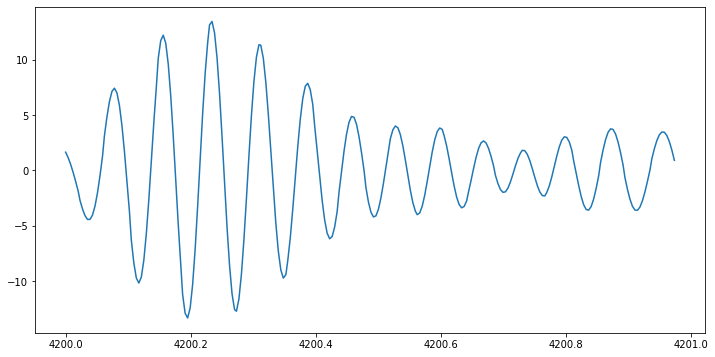

In [27]:
fig = plt.figure(figsize=(12,6))
time_1 = time[0:frame_len]
signal_1 = filtered[0:frame_len]
plt.plot(time_1, signal_1)
plt.ticklabel_format(useOffset=False)
plt.show()

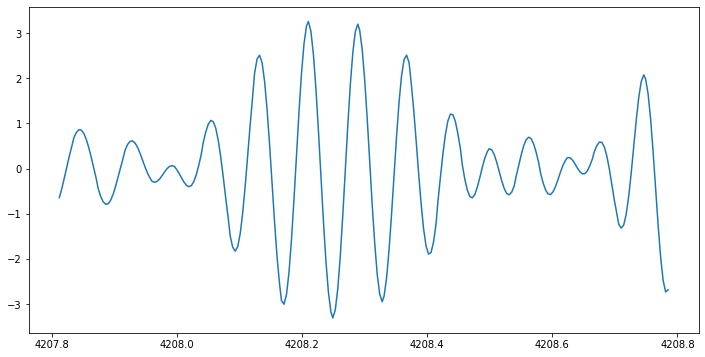

In [28]:
curr_shift_factor = 16
#curr_shift_factor = 5

fig = plt.figure(figsize=(12,6))
time_6 = time[0 + (curr_shift_factor*shift) : frame_len + (curr_shift_factor*shift)]
signal_6 = filtered[0 + (curr_shift_factor*shift) : frame_len + (curr_shift_factor*shift)]
plt.plot(time_6, signal_6)
plt.ticklabel_format(useOffset=False)
plt.show()

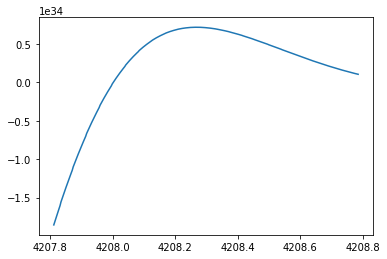

In [29]:
time_6 = time[0 + (curr_shift_factor*shift) : frame_len + (curr_shift_factor*shift)]
delta_window = delta[0 + (curr_shift_factor*shift) : frame_len + (curr_shift_factor*shift)]
plt.plot(time_6, delta_window)
plt.show()

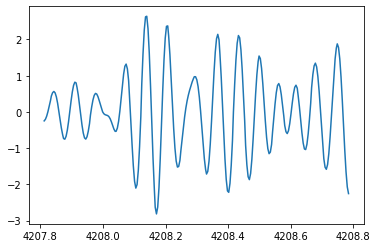

In [30]:
time_6 = time[0 + (curr_shift_factor*shift) : frame_len + (curr_shift_factor*shift)]
beta_window = beta[0 + (curr_shift_factor*shift) : frame_len + (curr_shift_factor*shift)]
plt.plot(time_6, beta_window)
plt.show()

<h2>Frame Matching With Scorer Annotations</h2>

<h3>Intersection Between Scorer 1 & 2 Annotations</h3>

In [31]:
scorer_1 = path + "\\" + scorer_annot_1
s1_df = pd.read_csv(scorer_1)
s1_df.columns = ['start', 'duration']
s1_df['end'] = s1_df['start'] + s1_df['duration']

# Make a temporary column for the start times rounded to the nearest integer:
s1_df['start_floor'] = s1_df['start'].astype('int32')

scorer_2 = path + "\\" + scorer_annot_2
s2_df = pd.read_csv(scorer_2)
s2_df.columns = ['start', 'duration']
s2_df['end'] = s2_df['start'] + s2_df['duration']

# Make a temporary column for the start times rounded to the nearest integer:
s2_df['start_floor'] = s2_df['start'].astype('int32')

# Get the 'inner join' of the two scorers' dataframes in order to get the ground truth.
scorer_inner = pd.merge(s1_df, s2_df, how='inner', on=['start_floor'])
scorer_inner.head()

# Take the mean of the start (onset) tie, duration of the spindle and the end time for each scorer:
scorer_final = pd.DataFrame()
scorer_final['start'] = (scorer_inner['start_x'] + scorer_inner['start_y']) / 2
scorer_final['duration'] = (scorer_inner['duration_x'] + scorer_inner['duration_y']) / 2
scorer_final['end'] = (scorer_inner['end_x'] + scorer_inner['end_y']) / 2

scorer_final.head()

,start,duration,end
0,905.642463,0.837840,906.480303
1,917.432942,1.312416,918.745359
2,949.362705,0.777293,950.139999
3,968.654275,1.156180,969.810455
4,978.624430,0.785106,979.409536


In [32]:
tmp = pd.DataFrame()
for col in scorer_final.columns:
    tmp[col] = scorer_final[col]
    
tmp2 = pd.DataFrame()
for col in scorer_final.columns:
    tmp2[col] = scorer_final[col]
    
tmp_final = pd.concat([tmp, tmp2], axis=0).reset_index(drop=True)
tmp_final = pd.concat([tmp_final, tmp2], axis=0).reset_index(drop=True)

tmp_final

,start,duration,end
0,905.642463,0.837840,906.480303
1,917.432942,1.312416,918.745359
2,949.362705,0.777293,950.139999
3,968.654275,1.156180,969.810455
4,978.624430,0.785106,979.409536
...,...,...,...
2281,28027.610380,0.921814,28028.532194
2282,28036.312985,1.185472,28037.498457
2283,28184.495795,0.947205,28185.443000
2284,28449.349115,0.831979,28450.181094


We want to see if the frames coincide with any of the start times in the intersection of the scorer's annotations. We'll use the very last frame we plottted to check if this is true. We are looking for the <i>start time</i> of the spindle to fall within the frame. 

If we treat the frame as a moving window, we'll manually classify the frame as a spindle if the annotation lies not only in the frame but if the window has moved more than 50% past the annotation itself. Let's see this in action.

In [33]:
# Take the time-vector from frame 6 and check if any of the spindle onset times fall in the time-vector:
condition = (scorer_final['start'] > min(time_6)) & (scorer_final['start'] < max(time_6))

# If this is true, we should see a particular spindle extracted from the annotations:
fall_in = scorer_final[condition]
fall_in

,start,duration,end
18,4207.885096,0.880803,4208.765899


In [34]:
fall_in.columns

Index(['start', 'duration', 'end'], dtype='object')

In [35]:
#len(fall_in['start'].astype(float))
len(fall_in)

1

An annotation has so happened to be in the 1.0 second frame that we captured from the epoch. Let's plot the onset on the same plot as the frame itself to see if our moving frame/window has succeed in capturing $\geq 50%$ of the spindle after the annotation onset.

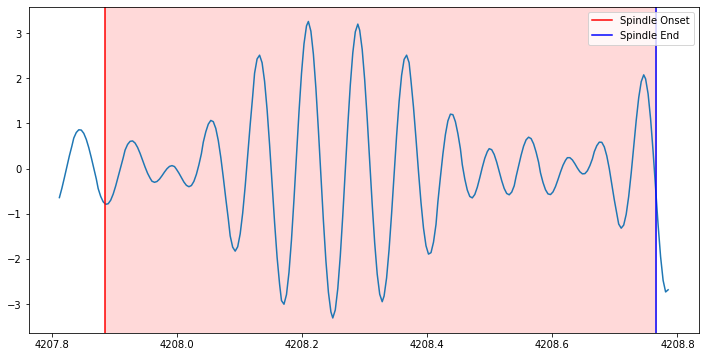

In [37]:
fig = plt.figure(figsize=(12,6))
plt.plot(time_6, signal_6)
plt.axvline(float(fall_in['start']), color='red', label='Spindle Onset')
plt.axvline(float(fall_in['end']), color='blue', label='Spindle End')
plt.axvspan(float(fall_in['start']), float(fall_in['end']), color='red', alpha=0.15)
plt.legend()
plt.show()

The above plot shows that our frame has captured a spindle and has moved more than 100ms (0.5 seconds) from the onset of the spindle annotation (marked in red). Since the frame is confidently sitting on top of an expertly scored spindle, we are free to classify the signal captured in this frame as a <b>spindle</b>. We'll check if that has been achieved for this particular scenario.

In [24]:
if (len(fall_in) == 0):
    s_or_ns = 0
else:
    # Check if the window has elapsed more than 50% of the window duration past the onset:
    elapsed = max(time_6) - fall_in['start']
    elapsed_percentage = float((((elapsed / Tw))) * 100)
    s_or_ns = 0
    if (elapsed_percentage >= 50.0):
        s_or_ns = 1
    else: 
        s_or_ns = 0
    print("Percentage Time Frame Elapsed After Onset = {}".format(elapsed_percentage))
    print("Label For Frame = {}".format(s_or_ns))


At this point, we are ready to take this spindle and derive a QPS that best fits this particular spindle. Using NLLS via ```lmfit```, we initialise the NLLS algorithm with the parameters and the model. Running the NLLS algorithm will perform the fitting and will produce the optimal QPS parameters for the fitted QPS. 

In [ ]:
from lmfit import Parameters, minimize

tmp = len(time_6)
sampling_rate = raw.info['sfreq']
t = np.arange(-tmp/(2*sampling_rate), (tmp-1)/(2*sampling_rate), 1/sampling_rate)

def residual(params, t, data):
	a, b, c = params['a'], params['b'], params['c']
	d, e, f = params['d'], params['e'], params['f']
	model = np.exp(a + b*t + c*t**2) * np.cos(d + e*t + f*t**2)
	chi = (data - model)
	return chi

a = 2.592191
b = 2.905482
c = -14.240023
d = 0.002717
e = 84.660186
f = -1.424085

params = Parameters()
params.add('a', value=a)
params.add('b', value=b)
params.add('c', value=c)
params.add('d', value=d)
params.add('e', value=e)
params.add('f', value=f)
    
out = minimize(residual, params, args=(t, signal_6))

# We now need to gather all the parameter values from the 'out' return from the minimize function
dict_params = {'a':0, 'b':0, 'c':0, 'd':0, 'e':0, 'f':0}
list_params = ['a','b','c','d','e','f']

for param in list_params:
    dict_params[param] = out.params[param].value
    
a, b, c = dict_params["a"], dict_params["b"], dict_params["c"]
d, e, f = dict_params["d"], dict_params["e"], dict_params["f"]
qps = np.exp(a + b*t + c*t**2) * np.cos(d + e*t + f*t**2)

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(time_6, signal_6)
ax.plot(time_6, qps)
#ax.plot(time_6, qps-signal_6)
plt.show()

In [ ]:
import lmfit
print(lmfit.__version__)

In [ ]:
from scipy.fftpack import fft, fftfreq, fftshift
from scipy.signal.windows import hann

window = hann(len(signal_6))
fft_raw = fftshift(2/len(signal_6) * np.abs(fft(signal_6 * window)))
fft_raw_x = fftshift(fftfreq(len(signal_6), d = 1/sampling_rate))
fft_qps = fftshift(2/len(qps) * np.abs(fft(qps*window)))

fig, ax = plt.subplots(figsize=(12,6))
ax.set_title("Frequency Spectrum Of Raw Signal and QPS", fontweight='bold', fontsize=16)
ax.set_ylabel("Amplitude", labelpad=15)
ax.set_xlabel("Frequency (Hz)", labelpad=15)
ax.plot(fft_raw_x, fft_raw, label='Raw Signal')
ax.plot(fft_raw_x, fft_qps, label='Fitted QPS')
ax.set_xlim([0,max(fft_raw_x)])
plt.legend()
plt.show()

<h2>Envelope Energy</h2>

Perhaps the energy content of the envelope of the QPS might be a feature that could be used to separate spindles from non-spindles. Recall the equation for the QPS again:

\begin{equation}
    s(t) = A(t) \cdot cos(d + et + ft^2)
\end{equation}

The Hilbert transform allows us to get $A(t)$ independent of the carrier component with which we can compute the power of. If the envelope is discrete, then the envelope power can be computed as:

\begin{equation}
    E_{env} = \sum_{n=0}^{N-1} |A[n]|^2
\end{equation}

A non-spindle is more likely to have an envelope that does not exhibit the rising and decaying shape of a spindle envelope. That is, a non-spindle envelope is more likely to have a low-amplitude than an envelope of a spindle.

In [ ]:
# Get the envelope of the computed (fitted) QPS.
from scipy.signal import hilbert
qps_env = abs(hilbert(qps))

# Compute the energy of the fitted QPS
qps_env_energy = np.sum(np.square(qps_env))

# Print out the energy value.
print("QPS Envelope Energy = {} uV^2".format(qps_env_energy))

<h2>Spindle-to-(Delta + Beta) Energy Ratio</h2>

In [ ]:
delta_energy = 1/len(delta_window) * np.sum(np.square(delta_window))
beta_energy = 1/len(beta_window) * np.sum(np.square(beta_window))
qps_energy = 1/len(qps) * np.sum(np.square(qps))

# Compute the ratio and add result to the dataframe.
spectral_energy_ratio = qps_energy / (delta_energy + beta_energy)
print(delta_energy)
print(beta_energy)
print(qps_energy)
print(spectral_energy_ratio)